# Initialization and helper functions

In [41]:
import json
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import numpy as np
from numpy import exp
import collections
from scipy import stats
import math
from statistics import stdev, mean
from fractions import Fraction as fr
import pandas as pd
from statistics import median

%matplotlib inline

INTENTS = ["quirky", "factoid", "music", "query", "set", "remove", "sendemail", "negate", "repeat", "explain"]
NUM_INTENTS = len(INTENTS)
NLU_NAMES = ['watson', 'luis', 'snips', 'rasa-sklearn', 'rasa-diet']
COLORS = ['lightcoral', 'yellowgreen', 'deepskyblue', 'purple', 'mediumturquoise', 'mediumorchid', 'khaki', 'salmon', 'darkturquoise', 'gold']
VERSION = 8
NUM_SPLITS = 10

def normalize(vector):
    normalized_vector = [v/sum(vector) for v in vector]
    return normalized_vector

def load_json(path):
    with open(path) as json_file:
        data = json.load(json_file)
    return data

def get_nlu_result_file(nlu, version, split_num):
    nlu_result_file = '../results/' + nlu + '/v' + str(version) + '/' + nlu + '_split_' + str(split_num) + '_results_v' + str(version) + '.json'
    return nlu_result_file

def get_confidence_score(test, rank=0, nlu="watson", level="rank"):
    """
    the output of this function differs depending on the level.
    On rank level, the output is a single float that represents the confidence score of a rank 
    On model level, the output is a list of floats that includes the confidence scores of all ranks
    """
    if level == "rank":
        predicted_intent_conf = test['intent_ranking'][rank]['confidence'] # rasa
        return predicted_intent_conf 
    
    else: # level == "model"
        predicted_confidences = [rank['confidence'] for rank in test['intent_ranking']]
        return predicted_confidences
    
def get_accuracy(test, rank=0, nlu="watson", level="rank"):
    """
    the output of this function differs depending on the level.
    On rank level, the output is a single int that represents the instance-level accuracy of a rank
    On model level, the output is a list of ints that includes the instance-level accuracies of all ranks
    """
    correct_intent = test['correct_intent']
    if level == "rank":
        predicted_intent = test['intent_ranking'][rank]['name']
        accuracy = int(correct_intent == predicted_intent)
        return accuracy
    else:
        test_accuracies = []
        test_accuracies = [rank['name'] == correct_intent for rank in test['intent_ranking']]
        return test_accuracies
    
def normalize_test(nlu, test, normalized_scores):
    """
    Updates scores in a test with normalized scores
    Input: test (json object) with non-normalized scores + list of normalized scores 
    Output: new test with normalized scores
    """
    for rank, score in enumerate(normalized_scores):
        test['intent_ranking'][rank]['confidence'] = score
    return test

def normalize_data(nlu, data):
    """ 
    This function normalizes all confidence scores in the json file
    Output: list of json objects (treated as list of dictionaries)
    """
    new_data = []
    for test in data:
        try:
            original_scores = get_confidence_score(test, nlu=nlu, level="model")
            normalized_scores = normalize(original_scores)
        except:
            normalized_scores = [0.1]*10
        if test['text'] != '':
            new_test = normalize_test(nlu, test, normalized_scores)
            new_data.append(new_test)
    return new_data

def remove_empty_preds(data):
    new_data = []
    for test in data:
        if test['text'] != '':
            new_data.append(test)
    return new_data


# Load NLU data

In [198]:
def load_nlu_data(nlu):
    def load_nlu_data_for_split_num(split_num):
        nlu_result_file = get_nlu_result_file(nlu, VERSION, split_num)
        return remove_empty_preds(load_json(nlu_result_file))
    return {
        split_num: load_nlu_data_for_split_num(split_num)
        for split_num in range(1, NUM_SPLITS+1)
    }

nlu_data = {
    nlu: load_nlu_data(nlu)
    for nlu in NLU_NAMES
}

# Non-contextual performance

In [199]:
from sklearn import metrics

In [200]:
all_nlus_f1_scores = []
all_nlus_accuracies = []

for i, nlu in enumerate(NLU_NAMES): 
    nlu_f1s = []
    nlu_accs = []
    for iteration in range(NUM_SPLITS):
        split_num = iteration + 1
        data = nlu_data[nlu][split_num]

        predicted_intents = []
        actual_intents = []
        for test in data:
            predicted = test['intent_ranking'][0]['name']
            actual = test['correct_intent']

            predicted_intents.append(predicted)
            actual_intents.append(actual)


        f1_score = metrics.f1_score(actual_intents, predicted_intents, average='macro')
        accuracy_score = metrics.accuracy_score(actual_intents, predicted_intents)
        nlu_f1s.append(f1_score)
        nlu_accs.append(accuracy_score)
    
    
    averaged_f1s = sum(nlu_f1s) / len(nlu_f1s)
    sd_f1 = stdev(nlu_f1s)
    median_f1 = np.median(nlu_f1s)
    averaged_accs = sum(nlu_accs) / len(nlu_accs)
    sd_acc = stdev(nlu_accs)
    median_acc = np.median(nlu_accs)
    all_nlus_f1_scores.append({'nlu': nlu, 'Mean': round(f1_score, 8), 'Median': round(median_f1, 8), 'standard deviation' : round(sd_f1, 8)})
    all_nlus_accuracies.append({'nlu': nlu, 'Mean': round(accuracy_score, 8), 'Median': round(median_acc, 8), 'standard deviation' : round(sd_acc, 8)})
        
all_nlus_f1_scores

[{'nlu': 'watson',
  'Mean': 0.9214412,
  'Median': 0.9197166,
  'standard deviation': 0.00233822},
 {'nlu': 'luis',
  'Mean': 0.88889647,
  'Median': 0.89300483,
  'standard deviation': 0.00407424},
 {'nlu': 'snips',
  'Mean': 0.89028629,
  'Median': 0.89166467,
  'standard deviation': 0.00217631},
 {'nlu': 'rasa-sklearn',
  'Mean': 0.79020273,
  'Median': 0.79561177,
  'standard deviation': 0.00357872},
 {'nlu': 'rasa-diet',
  'Mean': 0.81890462,
  'Median': 0.81716341,
  'standard deviation': 0.00330622}]

In [201]:
all_nlus_accuracies

[{'nlu': 'watson',
  'Mean': 0.92287342,
  'Median': 0.91996738,
  'standard deviation': 0.00225174},
 {'nlu': 'luis',
  'Mean': 0.88726089,
  'Median': 0.890405,
  'standard deviation': 0.0041371},
 {'nlu': 'snips',
  'Mean': 0.88990639,
  'Median': 0.89059627,
  'standard deviation': 0.00233196},
 {'nlu': 'rasa-sklearn',
  'Mean': 0.87263479,
  'Median': 0.87866153,
  'standard deviation': 0.00385567},
 {'nlu': 'rasa-diet',
  'Mean': 0.90376399,
  'Median': 0.89972545,
  'standard deviation': 0.00385903}]

# Contextual performance

In [256]:
import random

NUM_SAMPLES = 1000

def normal_distribution_curve(x, sigma=0.1, mu=0):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp( -(x - mu)**2 / (2 * sigma**2))

def fixed_context_distribution(context_strength):
    return normalize(1 + context_strength * normal_distribution_curve(np.linspace(0, 1, NUM_INTENTS)))

In [301]:
def sample_from_context(context):
    try:
        drawn_sample = np.random.multinomial(1, context, size=1)[0]
    except ValueError:
        print('Exception when trying to draw sample from context', context)
        raise
    intent_index = np.where(drawn_sample == 1)[0][0]
    return INTENTS[intent_index]

def get_intent_ranking(data, utterance):
    tests = [
        test
        for test in data
        if test['text'] == utterance
    ]
    if len(tests) == 0:
        raise Exception(f"Found no tests for '{utterance}'")
    return tests[0]['intent_ranking']

def get_confidence(intent, intent_ranking):
    for hypothesis in intent_ranking:
        if hypothesis['name'] == intent:
            return hypothesis['confidence']

def predict_intent(data, context, utterance):
    intent_ranking = get_intent_ranking(data, utterance)
    linguistic_prediction = normalize([get_confidence(intent, intent_ranking) for intent in INTENTS])
    contextualized_prediction = np.multiply(context, linguistic_prediction)
    predicted_intent_index = np.argmax(contextualized_prediction)
    predicted_intent = INTENTS[predicted_intent_index]
    return predicted_intent
    
def measure_performance_for_nlu_and_split(nlu, split_num, contexts, utterances):
    data = nlu_data[nlu][split_num]
    try:
        predicted_intents = [
            predict_intent(data, context, utterance)
            for context, correct_intent, utterance in zip(contexts, correct_intents, utterances)
        ]
    except Exception as exception:
        raise Exception(f"Failed to predict intents for nlu {nlu} split_num {split_num}: {exception}")
    return {'accuracy': metrics.accuracy_score(correct_intents, predicted_intents),
            'f1': metrics.f1_score(correct_intents, predicted_intents, average='macro')}

def measure_performance_for_nlu(nlu, contexts, utterances_per_split):
    performance_per_split = [
        measure_performance_for_nlu_and_split(nlu, split_num, contexts, utterances_per_split[split_num])
        for split_num in range(1, NUM_SPLITS + 1)
    ]
    accuracies = [
        split_performance['accuracy']
        for split_performance in performance_per_split
    ]
    f1s = [
        split_performance['f1']
        for split_performance in performance_per_split
    ]
    return {
        'accuracy': {
            'mean': mean(accuracies),
            'sd': stdev(accuracies)
        },
        'f1': {
            'mean': mean(f1s),
            'sd': stdev(f1s)
        }
    }

def pick_utterance(data, intent):
    candidates = [test["text"] for test in data if test["correct_intent"] == intent]
    return random.choice(candidates)
    
def pick_utterances_for_split(split_num, correct_intents):
    data = nlu_data[NLU_NAMES[0]][split_num]
    return [pick_utterance(data, intent) for intent in correct_intents]

def predict_intent_with_only_context(context):
    predicted_intent_index = np.argmax(context)
    predicted_intent = INTENTS[predicted_intent_index]
    return predicted_intent

def measure_performance_for_context(contexts, correct_intents):
    predicted_intents = [
        predict_intent_with_only_context(context)
        for context, correct_intent in zip(contexts, correct_intents)
    ]
    return {
        'accuracy': {
            'mean': metrics.accuracy_score(correct_intents, predicted_intents),
            'sd': 0
        },
        'f1': {
            'mean': metrics.f1_score(correct_intents, predicted_intents, average='macro'),
            'sd': 0
        }
    }

In [302]:
CONTEXT_STRENGTHS = np.linspace(0, 3, 10)

results_across_context_strengths = []
for context_strength in CONTEXT_STRENGTHS:
    context_distribution = fixed_context_distribution(context_strength)
    contexts = [np.random.permutation(context_distribution) for _ in range(NUM_SAMPLES)]
    correct_intents = [sample_from_context(context) for context in contexts]
    utterances_per_split = {
        split_num: pick_utterances_for_split(split_num, correct_intents)
        for split_num in range(1, NUM_SPLITS+1)
    }

    performances_per_nlu = {
        nlu: measure_performance_for_nlu(nlu, contexts, utterances_per_split)
        for nlu in NLU_NAMES
    }
    performances_per_nlu['context'] = measure_performance_for_context(contexts, correct_intents)
    results_across_context_strengths.append(performances_per_nlu)
    
results_across_context_strengths

[{'watson': {'accuracy': {'mean': 0.9184, 'sd': 0.008208396784864746},
   'f1': {'mean': 0.9166272714686016, 'sd': 0.008549257708529915}},
  'luis': {'accuracy': {'mean': 0.9054, 'sd': 0.010189319026422835},
   'f1': {'mean': 0.90406749147537, 'sd': 0.010535807398559294}},
  'snips': {'accuracy': {'mean': 0.9075, 'sd': 0.0051908038341324835},
   'f1': {'mean': 0.9055320554518542, 'sd': 0.00606895891393521}},
  'rasa-sklearn': {'accuracy': {'mean': 0.8741, 'sd': 0.01015928693910706},
   'f1': {'mean': 0.8717643565347043, 'sd': 0.01026927388151039}},
  'rasa-diet': {'accuracy': {'mean': 0.9033, 'sd': 0.006498717822257973},
   'f1': {'mean': 0.9016614028219668, 'sd': 0.007904561229216607}},
  'context': {'accuracy': {'mean': 0.083, 'sd': 0},
   'f1': {'mean': 0.015327793167128349, 'sd': 0}}},
 {'watson': {'accuracy': {'mean': 0.9114, 'sd': 0.011027239001672188},
   'f1': {'mean': 0.9088861681397082, 'sd': 0.01161363433855238}},
  'luis': {'accuracy': {'mean': 0.8991, 'sd': 0.0137149553407

## Accuracy for NLUs over context strength

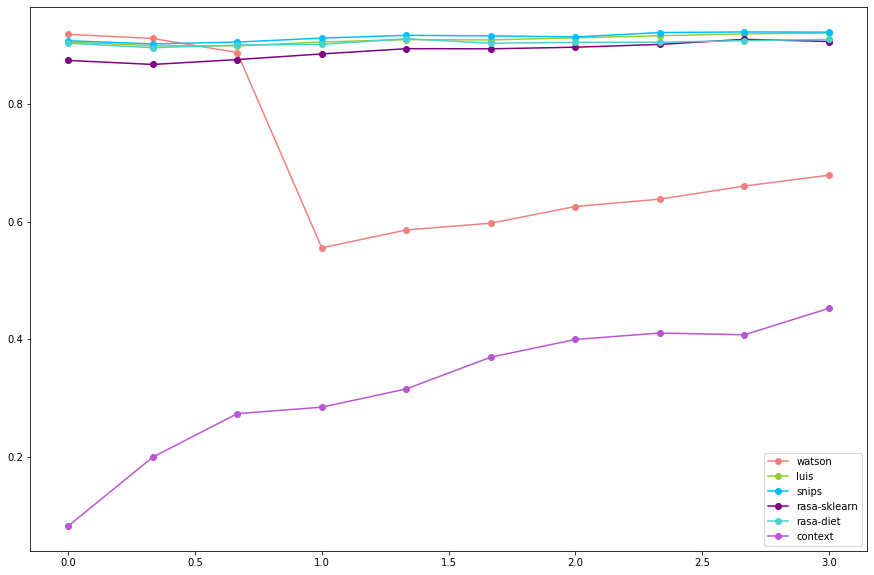

In [307]:
fig, ax = plt.subplots(figsize=(15, 10))
for i, nlu in enumerate(NLU_NAMES+["context"]):
    accuracies_mean = [result[nlu]['accuracy']['mean'] for result in results_across_context_strengths]
    #accuracies_sd = [result[nlu]['accuracy']['sd'] for result in results_across_context_strengths]
    accuracies_sd=None
    plt.errorbar(CONTEXT_STRENGTHS, accuracies_mean, fmt='o', yerr=accuracies_sd, ls='-', capsize=10, label=nlu, color=COLORS[i])
plt.legend()
plt.show()

In [ ]:
## Accuracy for NLUs with context, over accuracy for context only

In [ ]:
context_accuracy_scores = [result['context']['accuracy']['mean'] for result in results_across_context_strengths]
sorted_result_indexes = sorted(range(len(context_accuracy_scores)), key=lambda i: context_accuracy_scores[i])
sorted_context_accuracy_scores = [context_accuracy_scores[i] for i in sorted_result_indexes]
fig, ax = plt.subplots(figsize=(15, 10))
for i, nlu in enumerate(NLU_NAMES+["context"]):
    accuracies_mean = [result[nlu]['accuracy']['mean'] for result in results_across_context_strengths]
    #accuracies_sd = [result[nlu]['accuracy']['sd'] for result in results_across_context_strengths]
    accuracies_sd=None
    plt.errorbar(CONTEXT_STRENGTHS, accuracies_mean, fmt='o', yerr=accuracies_sd, ls='-', capsize=10, label=nlu, color=COLORS[i])
plt.legend()
plt.show()

## F1 score over context strength

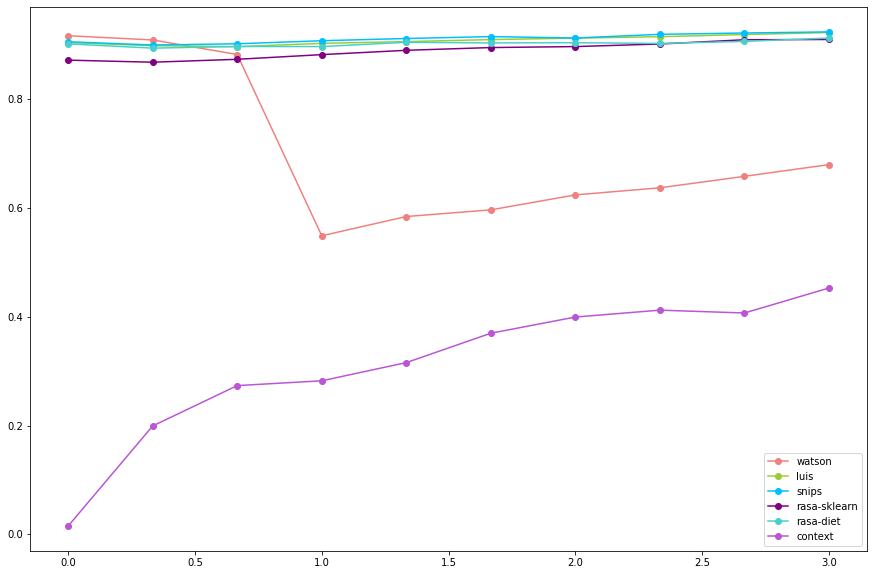

In [311]:
fig, ax = plt.subplots(figsize=(15, 10))
for i, nlu in enumerate(NLU_NAMES+["context"]):
    f1_mean = [result[nlu]['f1']['mean'] for result in results_across_context_strengths]
    #f1_sd = [result[nlu]['f1']['sd'] for result in results_across_context_strengths]
    f1_sd = None
    plt.errorbar(CONTEXT_STRENGTHS, f1_mean, fmt='o', yerr=f1_sd, ls='-', capsize=10, label=nlu, color=COLORS[i])
plt.legend()
plt.show()

## F1 score for NLUs with context, over F1 score for context only

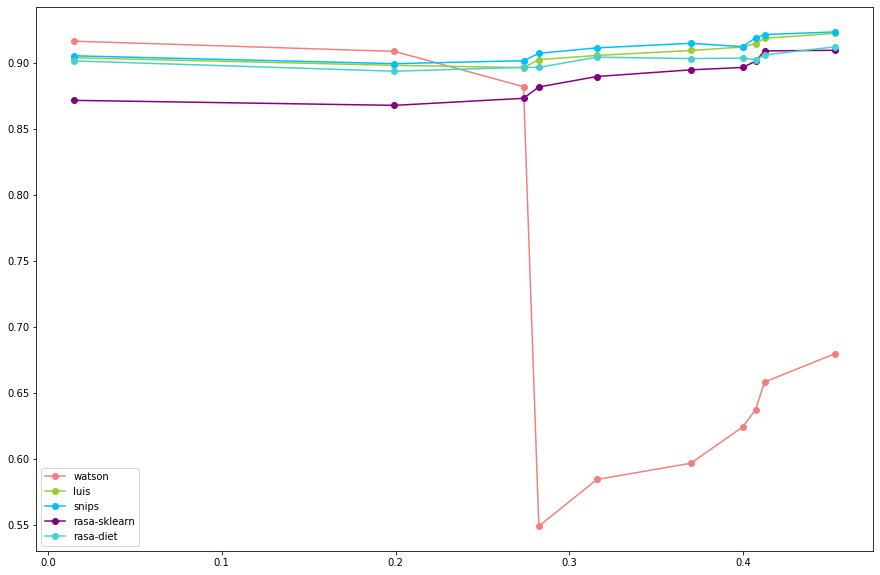

In [316]:
context_f1_scores = [result['context']['f1']['mean'] for result in results_across_context_strengths]
sorted_result_indexes = sorted(range(len(context_f1_scores)), key=lambda i: context_f1_scores[i])
sorted_context_f1_scores = [context_f1_scores[i] for i in sorted_result_indexes]
fig, ax = plt.subplots(figsize=(15, 10))
for i, nlu in enumerate(NLU_NAMES):
    result = results_across_context_strengths[sorted_result_indexes[i]]
    f1_mean = [
        results_across_context_strengths[sorted_result_indexes[i]][nlu]['f1']['mean']
        for i in sorted_result_indexes]
    f1_sd = None
    plt.errorbar(sorted_context_f1_scores, f1_mean, fmt='o', yerr=f1_sd, ls='-', capsize=10, label=nlu, color=COLORS[i])
plt.legend()
plt.show()